In [1]:
import elasticsearch
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
es = elasticsearch.Elasticsearch(hosts='http://ubu01.ramvarra.com:9200', timeout=240)

In [4]:
ix_pattern = 'tstat*'
q = {
    'query': {'match_all': {}},
    '_source': ['temp', 'name',]
}
r = es.search(index=ix_pattern, body=q)

In [5]:
last_n_days = 18
interval = '10m'
q = {
  "query": {
    "bool": {
      "must": [
        { "range": {
          "ts": {"gte": f"now-{last_n_days}d"}
        }}
      ]
    }
  }
  , "size": 0  
  , "aggs": {
      "BY_NAME": {
        "terms": {
          "field": "name",
          "size": 10
        }
        , "aggs": {
          "HOURLY": {
            "date_histogram": {
              "field": "ts",
              "interval": interval
            }
            , "aggs": {
              "AVG_TEMP": {
                "avg": {
                  "field": "temp"
                }
              }
            }
          }
        }
      }
  }
}

r = es.search(index=ix_pattern, body=q)
ix = []
data = []
for nm_bucket in r['aggregations']['BY_NAME']['buckets']:
    name = nm_bucket['key']
    for temp_bucket in nm_bucket['HOURLY']['buckets']:
        ts = datetime.datetime.fromtimestamp(temp_bucket['key']//1000)
        v = temp_bucket['AVG_TEMP']['value']
        ix.append(ts)
        data.append((name, v))
df = pd.DataFrame(data, index=ix, columns=['NAME', 'TEMP']).fillna(method='ffill')

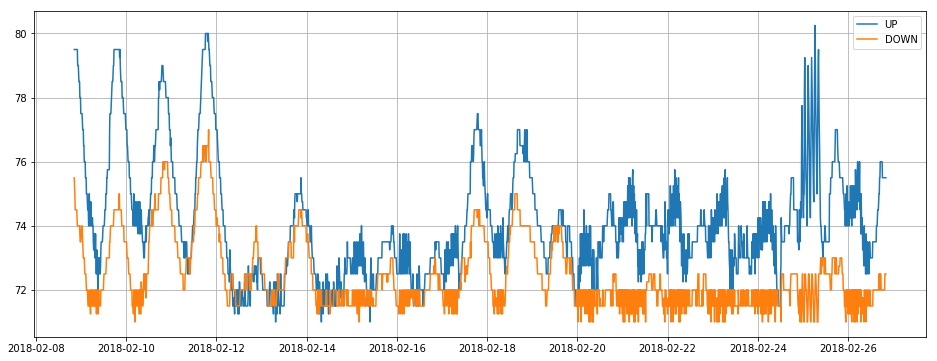

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(16,6))
ax.plot(df[df.NAME=='UP'].TEMP, label='UP')
ax.plot(df[df.NAME=='DOWN'].TEMP, label='DOWN')
ax.legend()
ax.grid()

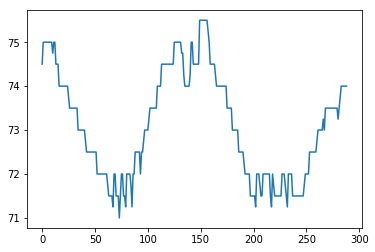

In [58]:
plt.plot(df[df.NAME=='DOWN'].TEMP)

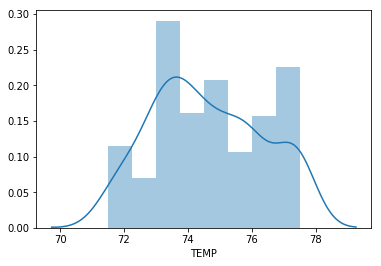

In [56]:
sns.distplot(df[df.NAME=='UP'].TEMP)

In [ ]:
sns.distplot(df[df.NAME=='UP'].TEMP)